In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
data = pd.read_csv('./SPY.csv')
data = data.drop(columns='Adj Close')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

1993-01-29 00:00:00 2020-05-08 00:00:00


,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,531500


In [3]:
columns = data.columns
for i in range(len(columns)):
    print(f"For column: {columns[i]}, max value is: {data[columns[i]].max()}, min value is: {data[columns[i]].min()}")

For column: Open, max value is: 337.790009, min value is: 43.34375
For column: High, max value is: 339.079987, min value is: 43.53125
For column: Low, max value is: 337.480011, min value is: 42.8125
For column: Close, max value is: 338.339996, min value is: 43.40625
For column: Volume, max value is: 871026300, min value is: 5200


In [4]:
data.index[6616]

Timestamp('2019-05-09 00:00:00')

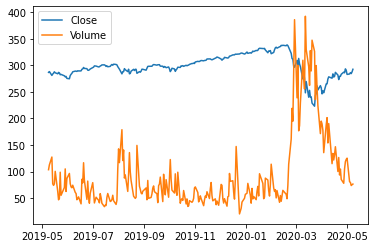

In [5]:
plt.plot(data.index[6616:], data['Close'][6616:], label="Close")
plt.plot(data.index[6616:], data['Volume'][6616:]/1000000, label="Volume")
plt.legend()

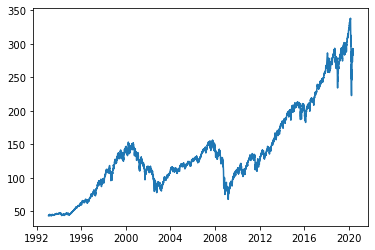

In [6]:
plt.plot(data.index, data['Close'], label="Close")

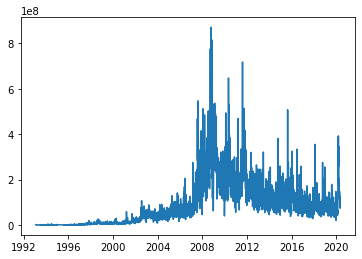

In [7]:
plt.plot(data.index, data['Volume'], label="Volume")

In [8]:
buckets=(21,21,21,21,21)
sarsa_table = np.zeros(buckets + (3,))

In [9]:
def find_bounds(data):
    print (data.shape)
    upper_bounds = [data['Open'].max(), data['High'].max(), data['Low'].max(), data['Close'].max(), data['Volume'].max()]
    lower_bounds = [data['Open'].min(), data['High'].min(), data['Low'].min(), data['Close'].min(), data['Volume'].min()]
    return upper_bounds, lower_bounds

In [10]:
def switch(f):
    ran = 0
    if f <= -0.2:
        ran = -20
    elif f < -0.1:
        ran = -10
    elif f < -0.05:
        ran = -5
    elif f < -0.04:
        ran = -4
    elif f < -0.03:
        ran = -3
    elif f < -0.02:
        ran = -2
    elif f < -0.01:
        ran = -1
    elif f < 0:
        ran = 0
    elif f < 0.01:
        ran = 1
    elif f < 0.02:
        ran = 2
    elif f < 0.03:
        ran = 3
    elif f < 0.04:
        ran = 4
    elif f < 0.05:
        ran = 5
    elif f < 0.1:
        ran = 10
    else:
        ran = 20
    return ran

In [11]:
def discretize_state(obs, base):
    discretized = list()
    for i in range(len(obs)):
        perc = (obs[i] - base[i]) / base[i]
        rank = switch(perc)
        discretized.append(rank)
    return tuple(discretized)

In [12]:
train_data = data[3761:6528]
test_data = data[6529:]

In [13]:
print(f"train period: {train_data.index.min()}-{train_data.index.max()}")
print(f"test period: {test_data.index.min()}-{test_data.index.max()}")

train period: 2008-01-04 00:00:00-2018-12-31 00:00:00
test period: 2019-01-03 00:00:00-2020-05-08 00:00:00


In [14]:
min_lr=0.01
min_epsilon=0.1
discount=0.98
decay=25
num_episodes=1000
actions = []
portfolio_worth = []
epsilon=0
learning_rate=0
market = train_data
done = False
commission_rate = 0.001
shares_hold = 0
balance = 50000
hold_price = 0

In [15]:
actions_list = ["hold","sell","buy"]
random.sample(actions_list, 1)

['sell']

In [16]:
def action_map(action):
    result = -1
    if action == "hold":
        result = 0
    if action == "sell":
        result = 1
    if action == "buy":
        result = 2
    return result

def action_map_decode(code):
    result = ""
    if code == 0:
        result = "hold"
    if code == 1:
        result = "sell"
    if code == 2:
        result = "buy"
    return result

def choose_action(state):
    global shares_hold
    if (np.random.random() < epsilon):
        #return self.env.action_space.sample() 
        if shares_hold > 0:
            actions_list = ["hold","sell"]
        else:
            actions_list = ["hold","buy"]
        return random.sample(actions_list, 1)[0]
    else:
        result = action_map_decode(np.argmax(sarsa_table[state]))
        if shares_hold > 0 and result == "buy":
            result = "hold"
        elif shares_hold == 0 and result == "sell":
            result = "hold"
        #print(f"choose action: {result}, share hold: {shares_hold}")
        return result

def update_sarsa(state, action, reward, new_state, new_action):
    action = action_map(action)
    new_action = action_map(new_action)
    sarsa_table[state][action] += learning_rate * (reward + discount * (sarsa_table[new_state][new_action]) - sarsa_table[state][action])

def get_epsilon(t):
    return max(min_epsilon, min(1., 1. - math.log10((t + 1) / decay)))

def get_learning_rate(t):
        return max(min_lr, min(1., 1. - math.log10((t + 1) / decay)))

In [17]:
def reset():
    global actions
    actions = []
    global portfolio_worth
    portfolio_worth = []
    global shares_hold
    shares_hold = 0
    global balance
    balance = 50000
    global hold_price
    hold_price = 0

In [18]:
def step(action, t):
    reward = 0
    global actions
    global portfolio_worth
    global commission_rate
    global balance
    global shares_hold
    global hold_price
    net_worth = 0
    if action == "buy":
        actions.append("buy")
        buy_price = market.iloc[t, :]['Close']
        if balance > buy_price:
            shares_hold = int(balance / buy_price)
            #print(f"shares_hold after buy: {shares_hold}")
            hold_price = buy_price
            balance = balance % buy_price
            net_worth = balance + shares_hold * buy_price * (1 - commission_rate)
            portfolio_worth.append(net_worth)
        else:
            net_worth = balance + shares_hold * buy_price
            portfolio_worth.append(net_worth)
        reward = market.iloc[t-1, :]['Close'] - buy_price
    elif action == "sell": 
        actions.append("sell")
        sell_price = market.iloc[t, :]['Close']
        balance = balance + shares_hold * sell_price * (1 - commission_rate)
        net_worth = balance
        shares_hold = 0
        reward = sell_price - market.iloc[t-1, :]['Close']
        reward += (sell_price - hold_price) * 10 # magnify the reward on sell
        hold_price = 0
        #print(f"net_worth after sell: {net_worth}")
        portfolio_worth.append(net_worth)
    else:
        actions.append("hold")
        portfolio_worth.append(balance + shares_hold * market.iloc[t, :]['Close'])
    # set next time
    t += 1
        
    if (t==len(market)-1):
        global done
        done=True
    return reward, t, done

In [19]:
def train(train_data):
    rows = train_data.shape[0]
    print(f"Start training, no of rows: {rows}")
    global market
    market = train_data
    for e in range(num_episodes):
        t = 1
        reset()
        current_state = discretize_state(train_data.values[1], train_data.values[0])

        global learning_rate
        learning_rate = get_learning_rate(e)
        global epsilon
        epsilon = get_epsilon(e)
        global done
        done = False
        print(f"Iteration: {e}, learning rate: {learning_rate}, epsilon: {epsilon}")

        while not done:
            action = choose_action(current_state)
            reward, t, done = step(action, t)
            new_state = discretize_state(train_data.values[t], train_data.values[t-1])
            new_action = choose_action(new_state)
            update_sarsa(current_state, action, reward, new_state, new_action)
            current_state = new_state
        print(f"net worth after 1 iteration: {portfolio_worth[-1]}")
    print('Finished training!')

In [20]:
train_data = data[3761:6528]
test_data = data[6529:]
sarsa_table = np.zeros(buckets + (3,))
reset()
train(train_data)

Start training, no of rows: 2767
Iteration: 0, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 22322.859009746022
Iteration: 1, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 31891.03485799803
Iteration: 2, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 39937.954801169006
Iteration: 3, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 28093.617448051064
Iteration: 4, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 87859.4664982902
Iteration: 5, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 39199.37979827608
Iteration: 6, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 38107.650594101004
Iteration: 7, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 70221.23855285505
Iteration: 8, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 45613.76681185088
Iteration: 9, learning rate: 1.0, epsilon: 1.0
net worth after 1 iteration: 18441.36339904395
Iteration: 10, learning 

net worth after 1 iteration: 74380.73662866486
Iteration: 72, learning rate: 0.5346171485515817, epsilon: 0.5346171485515817
net worth after 1 iteration: 74689.2240352421
Iteration: 73, learning rate: 0.5287082889410615, epsilon: 0.5287082889410615
net worth after 1 iteration: 96821.55597440808
Iteration: 74, learning rate: 0.5228787452803376, epsilon: 0.5228787452803376
net worth after 1 iteration: 70804.68801050477
Iteration: 75, learning rate: 0.5171264163912462, epsilon: 0.5171264163912462
net worth after 1 iteration: 56573.24938495221
Iteration: 76, learning rate: 0.5114492834995557, epsilon: 0.5114492834995557
net worth after 1 iteration: 94112.52435108909
Iteration: 77, learning rate: 0.5058454059815571, epsilon: 0.5058454059815571
net worth after 1 iteration: 102358.1307161628
Iteration: 78, learning rate: 0.5003129173815961, epsilon: 0.5003129173815961
net worth after 1 iteration: 64262.851447984795
Iteration: 79, learning rate: 0.49485002168009395, epsilon: 0.4948500216800939

net worth after 1 iteration: 117817.74360964906
Iteration: 137, learning rate: 0.25806092227080113, epsilon: 0.25806092227080113
net worth after 1 iteration: 108655.68913404102
Iteration: 138, learning rate: 0.25492520841794253, epsilon: 0.25492520841794253
net worth after 1 iteration: 141846.5441639082
Iteration: 139, learning rate: 0.25181197299379965, epsilon: 0.25181197299379965
net worth after 1 iteration: 124476.60466439663
Iteration: 140, learning rate: 0.2487208960166577, epsilon: 0.2487208960166577
net worth after 1 iteration: 107538.82922065262
Iteration: 141, learning rate: 0.2456516642889811, epsilon: 0.2456516642889811
net worth after 1 iteration: 112359.56409522585
Iteration: 142, learning rate: 0.24260397120697585, epsilon: 0.24260397120697585
net worth after 1 iteration: 136168.21603929772
Iteration: 143, learning rate: 0.23957751657678794, epsilon: 0.23957751657678794
net worth after 1 iteration: 157989.18610717758
Iteration: 144, learning rate: 0.23657200643706278, ep

net worth after 1 iteration: 233707.81860219853
Iteration: 202, learning rate: 0.09044397075882471, epsilon: 0.1
net worth after 1 iteration: 217583.35326624807
Iteration: 203, learning rate: 0.08830984124613883, epsilon: 0.1
net worth after 1 iteration: 317556.0045297953
Iteration: 204, learning rate: 0.08618614761628329, epsilon: 0.1
net worth after 1 iteration: 243261.11407772594
Iteration: 205, learning rate: 0.08407278830288423, epsilon: 0.1
net worth after 1 iteration: 287618.60570087767
Iteration: 206, learning rate: 0.08196966321511989, epsilon: 0.1
net worth after 1 iteration: 219197.5367557818
Iteration: 207, learning rate: 0.07987667370927609, epsilon: 0.1
net worth after 1 iteration: 297601.6742797741
Iteration: 208, learning rate: 0.0777937225609836, epsilon: 0.1
net worth after 1 iteration: 237140.8025016598
Iteration: 209, learning rate: 0.0757207139381183, epsilon: 0.1
net worth after 1 iteration: 163077.64017276096
Iteration: 210, learning rate: 0.07365755337434499, ep

net worth after 1 iteration: 342545.9376421956
Iteration: 280, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 275206.095411907
Iteration: 281, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 278768.58227844385
Iteration: 282, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 216886.2720015075
Iteration: 283, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 317318.9335745218
Iteration: 284, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 338507.85124518495
Iteration: 285, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 285295.81888235407
Iteration: 286, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 322324.8062572819
Iteration: 287, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 364457.0851560728
Iteration: 288, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 194894.99868963036
Iteration: 289, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration

net worth after 1 iteration: 319655.8003202786
Iteration: 365, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 360730.5116580558
Iteration: 366, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 245666.24561183123
Iteration: 367, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 279252.7002167419
Iteration: 368, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 268099.15307517187
Iteration: 369, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 393080.931423689
Iteration: 370, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 216846.3450820398
Iteration: 371, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 314337.508868494
Iteration: 372, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 256637.19518958047
Iteration: 373, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 349683.2370663736
Iteration: 374, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 

net worth after 1 iteration: 275420.4949136704
Iteration: 450, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 250047.97625705143
Iteration: 451, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 289625.1430637957
Iteration: 452, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 253942.4908579755
Iteration: 453, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 217764.6769944321
Iteration: 454, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 312349.6513835544
Iteration: 455, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 280164.1970096636
Iteration: 456, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 288339.260729102
Iteration: 457, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 364607.93109325756
Iteration: 458, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 317893.5656849065
Iteration: 459, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 

net worth after 1 iteration: 279348.59938229684
Iteration: 535, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 310561.84873196826
Iteration: 536, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 347155.6533907534
Iteration: 537, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 279880.9394373131
Iteration: 538, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 449565.3043325723
Iteration: 539, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 415634.1964414475
Iteration: 540, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 325048.8376957129
Iteration: 541, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 399748.2820332114
Iteration: 542, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 443645.9362753977
Iteration: 543, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 246881.93189984543
Iteration: 544, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration

net worth after 1 iteration: 289498.6272046935
Iteration: 620, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 466153.8764507677
Iteration: 621, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 270032.6760006097
Iteration: 622, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 284167.5856960704
Iteration: 623, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 322575.1115115168
Iteration: 624, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 340013.4207995951
Iteration: 625, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 391499.8791635763
Iteration: 626, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 298505.84764321416
Iteration: 627, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 306995.45572711906
Iteration: 628, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 489445.71890019876
Iteration: 629, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration

net worth after 1 iteration: 381500.18612489774
Iteration: 705, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 349552.03581911797
Iteration: 706, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 327354.22849822714
Iteration: 707, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 200370.805047155
Iteration: 708, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 278682.0708084504
Iteration: 709, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 351186.187106977
Iteration: 710, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 398819.77684410923
Iteration: 711, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 272854.94571701053
Iteration: 712, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 265476.74937521736
Iteration: 713, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 303292.82002375944
Iteration: 714, learning rate: 0.01, epsilon: 0.1
net worth after 1 iterati

net worth after 1 iteration: 300707.759109811
Iteration: 790, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 248699.0059485183
Iteration: 791, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 414948.7279317351
Iteration: 792, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 291213.75346559734
Iteration: 793, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 404118.74760397186
Iteration: 794, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 272423.4351763404
Iteration: 795, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 353912.6206393019
Iteration: 796, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 303319.4473445031
Iteration: 797, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 260312.01107112583
Iteration: 798, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 396082.3601278329
Iteration: 799, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration:

net worth after 1 iteration: 305639.10632116674
Iteration: 875, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 278135.39362338925
Iteration: 876, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 332330.75365967245
Iteration: 877, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 344452.28847350035
Iteration: 878, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 145877.18440540493
Iteration: 879, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 360062.5720966496
Iteration: 880, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 318956.9606147064
Iteration: 881, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 245788.5396843707
Iteration: 882, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 191314.79337364316
Iteration: 883, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 337404.00449285685
Iteration: 884, learning rate: 0.01, epsilon: 0.1
net worth after 1 itera

net worth after 1 iteration: 305524.91083853866
Iteration: 959, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 278059.46132111276
Iteration: 960, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 191151.29548493813
Iteration: 961, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 232214.73480473596
Iteration: 962, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 314873.0077241764
Iteration: 963, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 326039.86007147754
Iteration: 964, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 228833.39289473725
Iteration: 965, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 218171.1188212789
Iteration: 966, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 266948.6872304495
Iteration: 967, learning rate: 0.01, epsilon: 0.1
net worth after 1 iteration: 281803.8837749771
Iteration: 968, learning rate: 0.01, epsilon: 0.1
net worth after 1 iterat

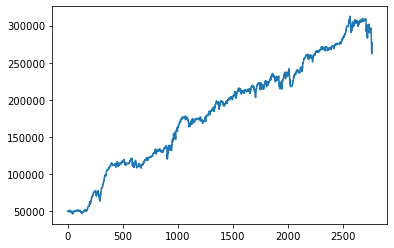

In [21]:
plt.plot(portfolio_worth)

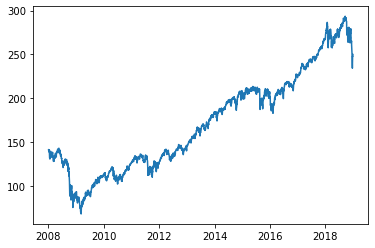

In [22]:
plt.plot(train_data['Close'])

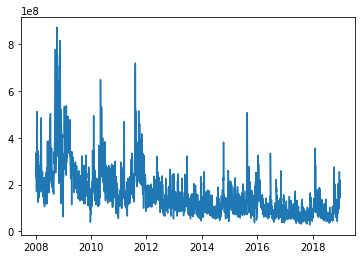

In [23]:
plt.plot(train_data['Volume'])

In [24]:
def step_buy_and_hold(t):
    global commission_rate
    global benchmark_balance
    global benchmark_worth
    global benchmark_shares_hold
    current_price = market.iloc[t, :]['Close']
    if t == 1:
        benchmark_shares_hold = int(benchmark_balance / current_price)
        #print(f"benchmark_shares_hold after buy: {benchmark_shares_hold}")
        benchmark_balance = benchmark_balance % current_price
        net_worth = benchmark_balance + benchmark_shares_hold * current_price * (1 - commission_rate)
        benchmark_worth.append(net_worth)
    else:
        net_worth = benchmark_balance + benchmark_shares_hold * current_price
        benchmark_worth.append(net_worth)

In [104]:
def run(test_data):
    rows = test_data.shape[0]
    print(f"Start testing, no of rows: {rows}")
    global market
    market = test_data
    t = 1
    global done
    done = False
    current_state = discretize_state(test_data.values[1], test_data.values[0])
    print(f"current state: {current_state}")
    while not done:
        #action = choose_action(current_state) # Enable Epsilon_Greedy selection
        action = choose_action_test(current_state)
        print(f"Interation: {t}, Action: {action}")
        step_buy_and_hold(t)
        reward, t, done = step(action, t)
        new_state = discretize_state(test_data.values[t], test_data.values[t-1])
        print(f"Interation: {t}, New State: {new_state}")
        current_state = new_state
            
    return t   

In [105]:
def choose_action_test(state):
    result = action_map_decode(np.argmax(sarsa_table[state]))
    if shares_hold > 0 and result == "buy":
        result = "hold"
    elif shares_hold == 0 and result == "sell":
        result = "hold"
    #print(f"choose action: {result}, share hold: {shares_hold}")
    return result

In [159]:
#test_data = data[3500:] # Making profit over the long run
#test_data = data[6527:6552] # Test period for 1 month
#test_data = data[6527:6591] # Test period for 3 months
#test_data = data[6527:6654] # Test period for 6 months
test_data = data[6527:] # Test period for comparison with other models
benchmark_balance = 50000
benchmark_worth = []
benchmark_shares_hold = 0
global market
market = test_data
reset()
run(test_data)

Start testing, no of rows: 342
current state: (-1, 1, 0, 1, -10)
Interation: 1, Action: hold
Interation: 2, New State: (1, -1, 0, -2, 20)
Interation: 2, Action: hold
Interation: 3, New State: (0, 2, 2, 4, -1)
Interation: 3, Action: buy
Interation: 4, New State: (3, 2, 2, 1, -20)
Interation: 4, Action: hold
Interation: 5, New State: (2, 1, 1, 1, 0)
Interation: 5, Action: sell
Interation: 6, New State: (1, 1, 1, 1, -5)
Interation: 6, Action: hold
Interation: 7, New State: (0, 1, 0, 1, 2)
Interation: 7, Action: hold
Interation: 8, New State: (1, 0, 1, 1, -20)
Interation: 8, Action: hold
Interation: 9, New State: (0, 0, 0, 0, -3)
Interation: 9, Action: buy
Interation: 10, New State: (1, 1, 1, 2, 20)
Interation: 10, Action: sell
Interation: 11, New State: (2, 1, 2, 1, -5)
Interation: 11, Action: buy
Interation: 12, New State: (0, 1, 0, 1, 20)
Interation: 12, Action: sell
Interation: 13, New State: (2, 2, 2, 2, 20)
Interation: 13, Action: hold
Interation: 14, New State: (0, 0, 0, -1, -5)
Int

341

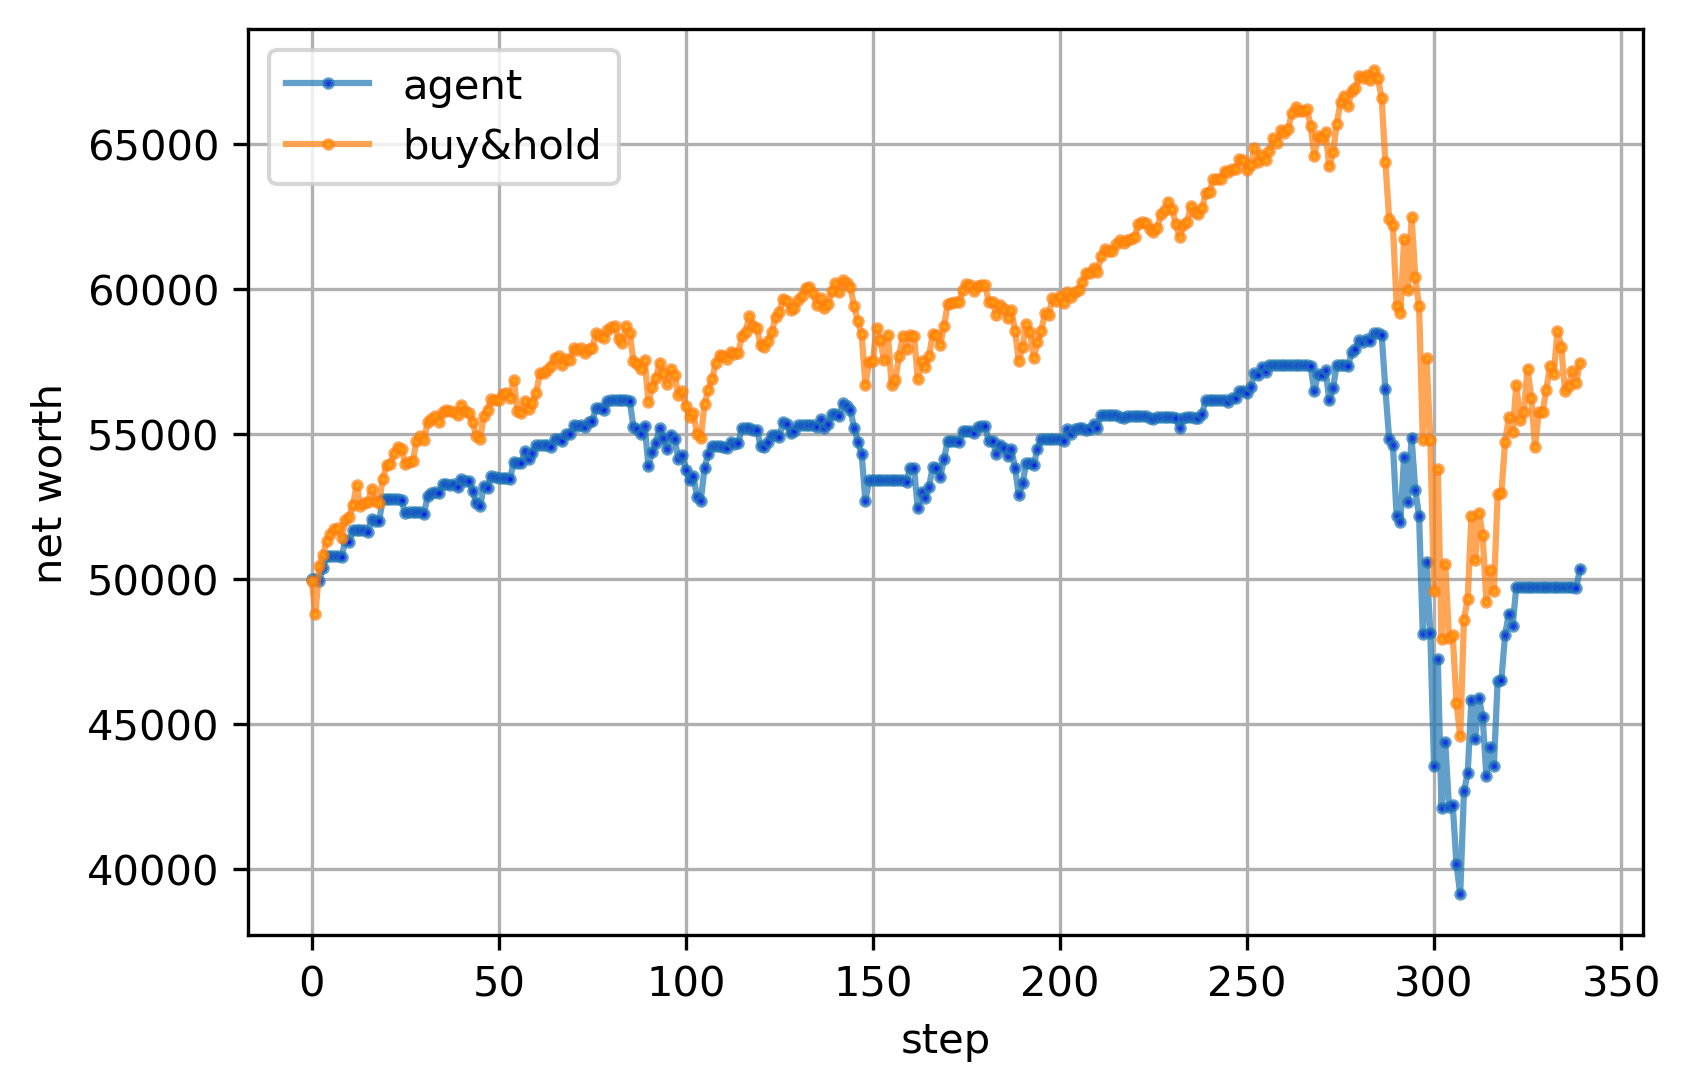

In [160]:
plt.plot(portfolio_worth, '-o', label='agent', marker='o', ms=2, alpha=0.7, mfc='blue')
plt.plot(benchmark_worth, '-o', label='buy&hold', marker='o', ms=2, alpha=0.7, mfc='orange')
plt.grid()
plt.xlabel('step')
plt.ylabel('net worth')
plt.legend()
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.show()

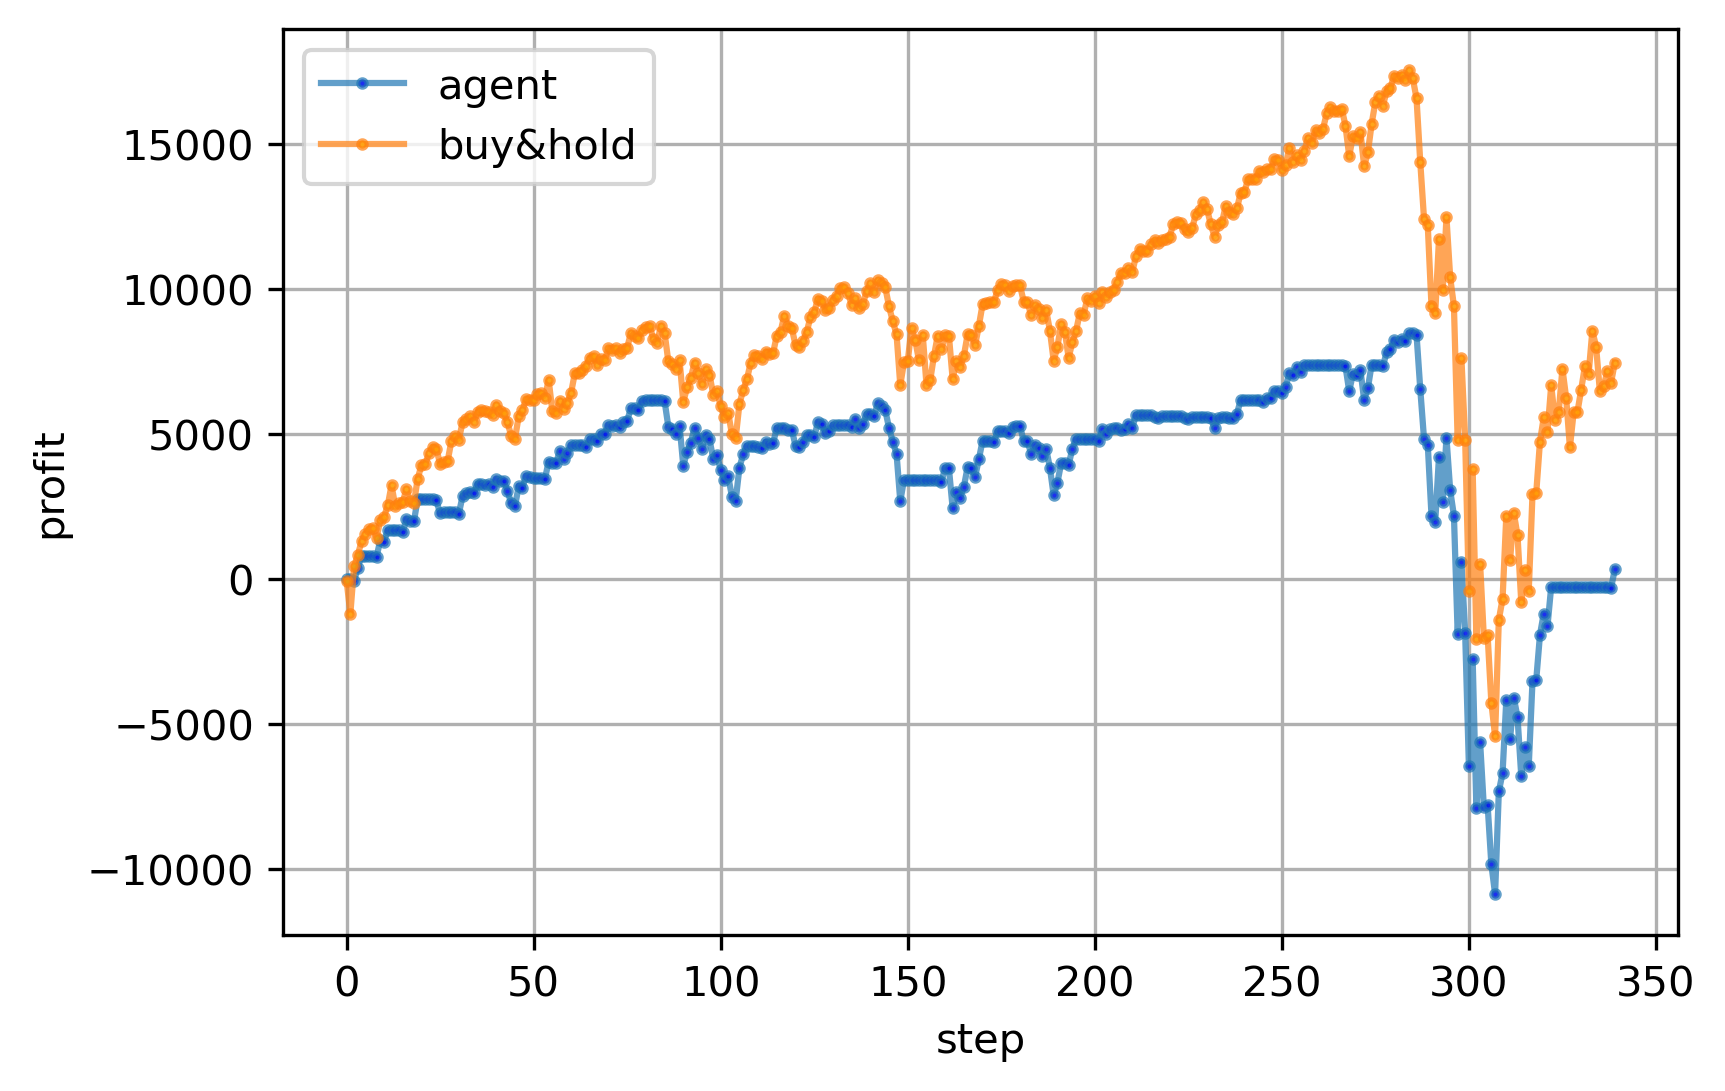

In [161]:
plt.plot([x - 50000 for x in portfolio_worth], '-o', label='agent', marker='o', ms=2, alpha=0.7, mfc='blue')
plt.plot([x - 50000 for x in benchmark_worth], '-o', label='buy&hold', marker='o', ms=2, alpha=0.7, mfc='orange')
plt.grid()
plt.xlabel('step')
plt.ylabel('profit')
plt.legend()
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.show()

In [60]:
actions[-20:]

['hold',
 'hold',
 'hold',
 'hold',
 'hold',
 'hold',
 'hold',
 'hold',
 'hold',
 'sell',
 'buy',
 'sell',
 'hold',
 'buy',
 'hold',
 'sell',
 'buy',
 'sell',
 'hold',
 'hold']

In [42]:
sarsa_table[(1, 0, 1, 0, -20, 0)]

48.462566424685456

In [43]:
sarsa_table[(1, 0, 1, 0, -20, 1)]

35.7378352206136

In [44]:
sarsa_table[(1, 0, 1, 0, -20, 2)]

49.049143012290905

In [45]:
for i in range(3):
    print(f"state: (1, 0, 1, 0, -20), Q value for action-{i}: {sarsa_table[(1, 0, 1, 0, -20, i)]}")

state: (1, 0, 1, 0, -20), Q value for action-0: 48.462566424685456
state: (1, 0, 1, 0, -20), Q value for action-1: 35.7378352206136
state: (1, 0, 1, 0, -20), Q value for action-2: 49.049143012290905
